# Import Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from prophet import Prophet

# Data Preprocessing

In [29]:
# Load the data
data = pd.read_excel('yahoo_data.xlsx')

In [30]:
data.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [32]:
data.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [33]:
data.describe()

,Open,High,Low,Close*,Adj Close**,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


In [34]:
# Rename column for consistency
data.columns = ['Date', 'open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

In [35]:
# Convert Date to datetime 
data['Date'] = pd.to_datetime(data['Date'])

In [36]:
# Sort Data By Date
data = data.sort_values("Date").reset_index(drop=True)

In [37]:
# Convert numbers to float
numeric_cols = ['open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
data[numeric_cols] = data[numeric_cols].replace(',', '', regex=True).astype(float)

In [38]:
data.head()

,Date,open,High,Low,Close,Adj_Close,Volume
0,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000.0
1,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000.0
2,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000.0
3,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000.0
4,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000.0


# Financial Indicators

In [39]:
# simple Moving Average (SMA)
data['SMA_20'] = data['Close'].rolling(window=20).mean()

In [40]:
# Exponential Moving Average (EMA)
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

In [41]:
# Bollinger Bonds
# First calculate SMA (Simple Moving Average) and rolling standard deviation
data['SMA_20'] = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()

# Now calculate the Bollinger Bands
data['BB_upper'] = data['SMA_20'] + (2 * rolling_std)
data['BB_lower'] = data['SMA_20'] - (2 * rolling_std)


In [42]:
# RSI (Relative Strength Index)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Anomaly Detection (Isolation Forest or DBSCAN)

1. Using Isolation Forest: 

In [43]:
# Use Selected features
features = data[['Close', 'SMA_20', 'EMA_20', 'RSI']].dropna()

In [44]:
# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
data.loc[features.index, 'anomaly_iso'] = iso_forest.fit_predict(features)

In [45]:
# Label Anomalies
data['anomaly_iso'] = data['anomaly_iso'].map({1: 0, -1: 1})

2. Using DBSCAN:

In [46]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [47]:
# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

In [48]:
# Mark anomalies (label = -1)
data.loc[features.index, 'anomaly_dbscan'] = (labels == -1).astype(int)

# Forecasting with Prophet (to detect deviations)

In [49]:
# Prepare data for Prophet
df_prophet = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [50]:
# Fit model
model = Prophet()
model.fit(df_prophet)

16:35:32 - cmdstanpy - INFO - Chain [1] start processing
16:35:32 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Predict Future
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

In [52]:
# Merge actual and forecast
df_forecast = df_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Visualize Anomalies

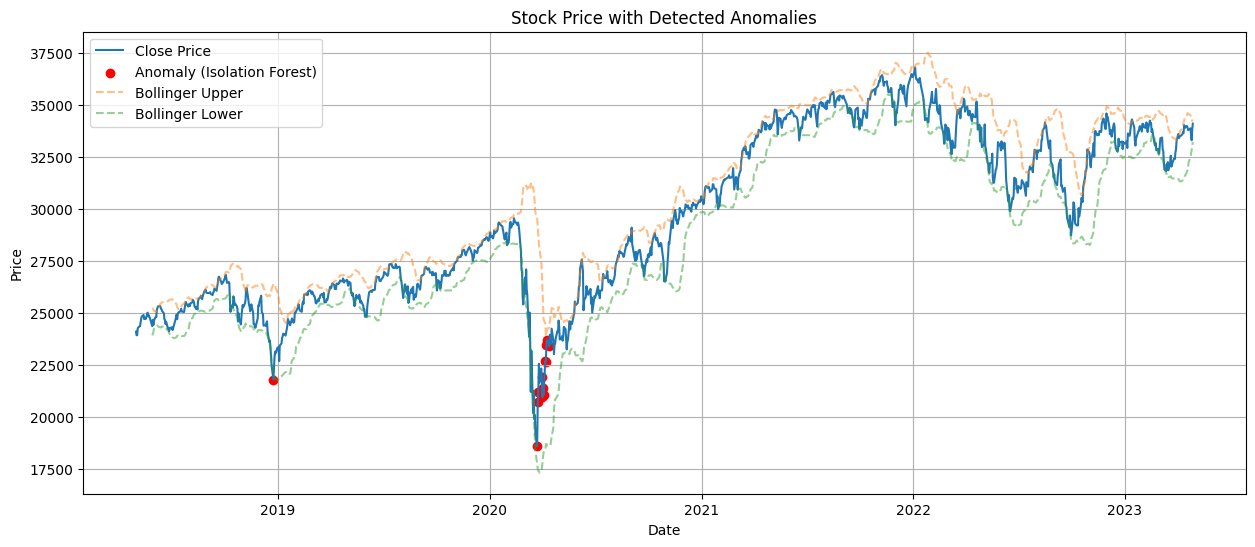

In [53]:
# Plot anomalies on close price
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Close'], label = 'Close Price')
plt.scatter(data[data['anomaly_iso'] == 1]['Date'], data[data['anomaly_iso'] == 1]['Close'], color='red', label='Anomaly (Isolation Forest)')
plt.plot(data['Date'], data['BB_upper'], linestyle='--', alpha=0.5, label='Bollinger Upper')
plt.plot(data['Date'], data['BB_lower'], linestyle='--', alpha=0.5, label='Bollinger Lower')
plt.title("Stock Price with Detected Anomalies")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Outcome
1. A tool that detects outliers using statistical indicators and machine learning
2. Plots stock price anomalies
3. Prophet shows predicted vs actual trend